# Choosing a location for an oil well

Let's say you work for the mining company "GlavRosGosNeft". We need to decide where to drill a new well.

You have been provided with oil samples in three regions: in each of 10 000 fields, where the quality of oil and the volume of its reserves have been measured. Build a machine learning model to help determine the region where mining will bring the most profit. Analyze possible profits and risks using the *Bootstrap.* technique

Steps to choose a location:

- In the selected region, they are looking for deposits, for each, the values of the signs are determined;
- Build a model and estimate the volume of reserves;
- Select the deposits with the highest value estimates. The number of fields depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected deposits.


**Data Description:**

Geological exploration data of three regions are in the files:

- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`
- **`id`** — unique identifier of the well;
- **`f0`**, **`f1`**, **`f2`** - three signs of dots (it doesn't matter what they mean, but the signs themselves are significant);
- **`product`** — volume of reserves in the well (thousand barrels).

**Conditions of the problem:**

- For model training, **only linear regression** is suitable (the rest are not predictable enough).
- When exploring a region, **500 wells** are explored, from which, using machine learning, the **200 best** are selected for development.
- The budget for the development of wells in the region is **10 billion rubles**.
- At current prices, one barrel of raw materials brings **450 rubles** of income. The income from each unit of the product is **450 thousand rubles**, since the volume is indicated in thousands of barrels.
- After assessing the risks, you need to leave only those regions in which the probability of losses is less than **2.5%**. Among them, choose the region with the highest average profit.

Synthetic data: details of contracts and characteristics of deposits were not disclosed.

## Loading and preparing data

We import everything that is needed in the project:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Let's read and see our data.

In [2]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

**General overview (data types/missings)**

In [3]:
print('=====df1=====')
df1.info()
print('=====df2=====')
df2.info()
print('=====df3=====')
df3.info()

=====df1=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
=====df2=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
=====df3=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns 

**Duplicates**

In [4]:
print(df1.duplicated().sum(), df2.duplicated().sum(), df3.duplicated().sum())

0 0 0


### Features overview

Let's see how oil reserves are distributed for each of the three files.

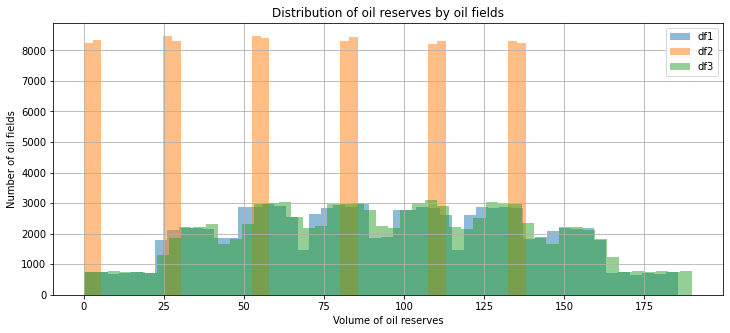

In [5]:
df1['product'].hist(figsize=(12, 5), bins = 50, alpha=0.5, label = 'df1')
df2['product'].hist(figsize=(12, 5), bins = 50, alpha=0.5, label = 'df2')
df3['product'].hist(figsize=(12, 5), bins = 50, alpha=0.5, label = 'df3')
plt.title('Distribution of oil reserves by oil fields')
plt.legend(loc ='upper right')
plt.xlabel("Volume of oil reserves")
plt.ylabel("Number of oil fields")
plt.show()

Data set 2 looks very strange, one can only guess about the reasons for this distribution.

**Estimate the multicollinearity of features**

It is important to check if there are strong relationships in features that can interfere with model training.

**Set 1**

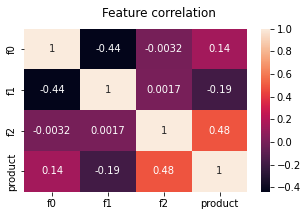

CPU times: user 418 ms, sys: 44.7 ms, total: 463 ms
Wall time: 226 ms


In [6]:
%%time
fig, ax = plt.subplots(figsize=(5,3))    

sns.heatmap(df1.corr(), annot = True,  ax = ax)
plt.suptitle("Feature correlation")
plt.show()

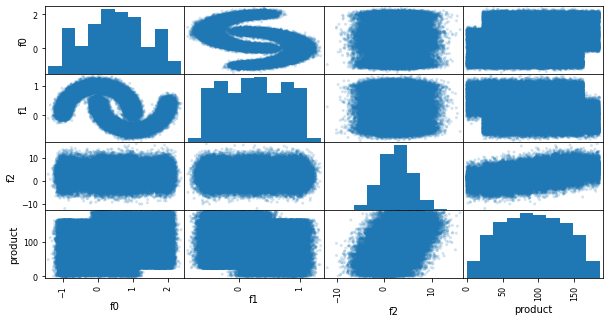

CPU times: user 4.96 s, sys: 82 ms, total: 5.04 s
Wall time: 4.83 s


In [7]:
%%time
pd.plotting.scatter_matrix(df1, alpha = 0.2, figsize = (10, 5))
plt.show()

- product - f2 (**0.48**)
- f1 - f0, the relationship is not linear, therefore, the value in the correlation matrix is very small

**Set 2**

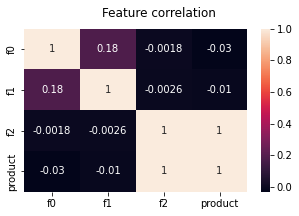

CPU times: user 351 ms, sys: 54.2 ms, total: 406 ms
Wall time: 172 ms


In [8]:
%%time
fig, ax = plt.subplots(figsize=(5,3))    

sns.heatmap(df2.corr(), annot = True,  ax = ax)
plt.suptitle("Feature correlation")
plt.show()

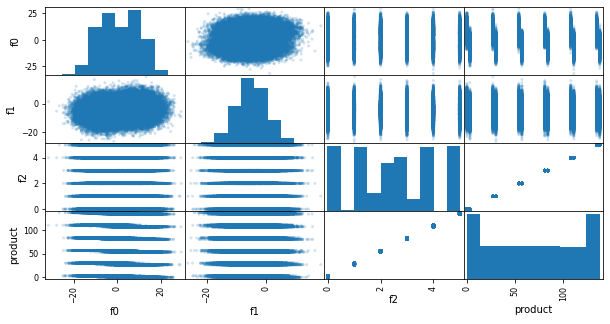

CPU times: user 4.81 s, sys: 77.1 ms, total: 4.88 s
Wall time: 4.66 s


In [9]:
%%time
pd.plotting.scatter_matrix(df2, alpha = 0.2, figsize = (10, 5))
plt.show()

The oddities with the set continue, now we see 100% correlation of the feature pair **product - f2**

**Set 3**

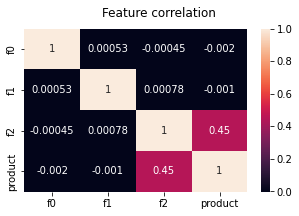

CPU times: user 361 ms, sys: 46.3 ms, total: 407 ms
Wall time: 169 ms


In [10]:
%%time
fig, ax = plt.subplots(figsize=(5,3))    

sns.heatmap(df3.corr(), annot = True,  ax = ax)
plt.suptitle("Feature correlation")
plt.show()

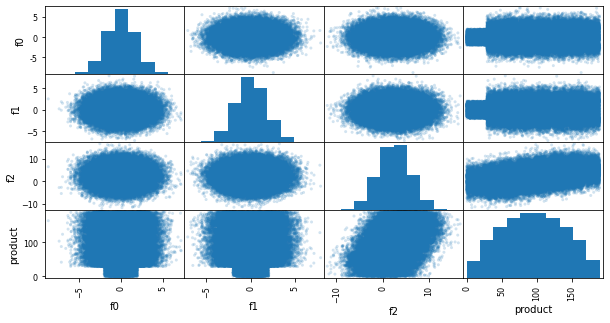

CPU times: user 5.12 s, sys: 92 ms, total: 5.21 s
Wall time: 4.99 s


In [11]:
%%time
pd.plotting.scatter_matrix(df3, alpha = 0.2, figsize = (10, 5))
plt.show()

- product - f2 (**0.45**)

**Conclusion:**

- read and looked at datasets by region
- made a check for obvious duplicates and missings
- looked at how the volume of reserves is distributed depending on the region, found an abnormal distribution in region 2
- also evaluated pairwise correlations of features in the proposed files. the second region shows a strong dependence of the volume of the product on the feature f2. This tells us that it is the feature f2 that has the maximum impact on the volume of the deposit in the second region.

## Train and validate the model

### We split the data into training and validation samples in the ratio of 75:25

**We first remove the `id`, it will not be needed for training and analysis of the results**

In [12]:
for i in [df1, df2, df3]:
    i = i.drop(['id'], axis = 1, inplace = True)

In [13]:
model_ln_r = LinearRegression()

**Set 1**

In [14]:
features = df1.drop('product', axis= 1)
target = df1['product']

In [15]:
features_train_df1, features_test_df1, target_train_df1, target_test_df1 = train_test_split(
                       features, target, test_size = 0.25, random_state = 12345)
## split check
print(len(features_train_df1)/len(df1), len(target_train_df1)/len(df1))

0.75 0.75


In [16]:
model_ln_r.fit(features_train_df1, target_train_df1)
predic_df1 = model_ln_r.predict(features_test_df1)

Let's print the average predicted oil reserve and RMSE model

In [17]:
print('Average oil reserve fact', target_test_df1.mean())
print('Average oil reserve predict', predic_df1.mean())
print('RMSE', mean_squared_error(target_test_df1, predic_df1) ** 0.5)

Average oil reserve fact 92.07859674082941
Average oil reserve predict 92.59256778438035
RMSE 37.5794217150813


In [18]:
print('Feature - Feature Importance')
for feature, coeff in zip(df1.columns, model_ln_r.coef_.T):
    print(feature, coeff)

Feature - Feature Importance
f0 3.5928058490640447
f1 -14.097944194480634
f2 6.593166172509485


**Set 2**

In [19]:
features = df2.drop('product', axis= 1)
target = df2['product']

In [20]:
features_train_df2, features_test_df2, target_train_df2, target_test_df2 = train_test_split(
                       features, target, test_size = 0.25, random_state = 12345)
## split check
print(len(features_train_df2)/len(df2), len(target_train_df2)/len(df2))

0.75 0.75


In [21]:
model_ln_r.fit(features_train_df2, target_train_df2)
predic_df2 = model_ln_r.predict(features_test_df2)

Let's print the average predicted oil reserve and RMSE model

In [22]:
print('Average oil reserve fact', target_test_df2.mean())
print('Average oil reserve predict', predic_df2.mean())
print('RMSE', mean_squared_error(target_test_df2, predic_df2) ** 0.5)

Average oil reserve fact 68.72313602437494
Average oil reserve predict 68.728546895446
RMSE 0.893099286775617


In [23]:
print('Feature - Feature Importance')
for feature, coeff in zip(df2.columns, model_ln_r.coef_.T):
    print(feature, coeff)

Feature - Feature Importance
f0 -0.14494096735303977
f1 -0.022027854174969413
f2 26.95118049538883


**Set 3**

In [25]:
features = df3.drop('product', axis= 1)
target = df3['product']

In [26]:
features_train_df3, features_test_df3, target_train_df3, target_test_df3 = train_test_split(
                       features, target, test_size = 0.25, random_state = 12345)
## split check
print(len(features_train_df3)/len(df3), len(target_train_df3)/len(df3))

0.75 0.75


In [27]:
model_ln_r.fit(features_train_df3, target_train_df3)
predic_df3 = model_ln_r.predict(features_test_df3)

In [28]:
print('Average oil reserve fact', target_test_df3.mean())
print('Average oil reserve predict', predic_df3.mean())
print('RMSE', mean_squared_error(target_test_df3, predic_df3) ** 0.5)

Average oil reserve fact 94.88423280885489
Average oil reserve predict 94.96504596800489
RMSE 40.02970873393434


In [29]:
print('Feature - Feature Importance')
for feature, coeff in zip(df3.columns, model_ln_r.coef_.T):
    print(feature, coeff)

Feature - Feature Importance
f0 0.030935725376218248
f1 -0.04187718522708295
f2 5.708542431435447


**Conclusion:**

- split all three sets into training and test sets
- trained a linear regression model and made a prediction on the test
- looked at the coefficients for each of the indicators in the model
- the minimum RMSE value was obtained for model 2 **(0.89)**, it can be considered the most accurate (I believe this is due to the specifics of the data in this set)
- while the average oil reserve in the second region is minimal
- the results for the average reserve of deposits on the test `prediction - true value` differ slightly

## Preparation for profit calculation

It is necessary to calculate a sufficient volume of oil reserves for break-even development of a new well. Compare the received volume of raw materials with the average stock in each region


- During the exploration of the region, **500 wells** are explored, from which, using machine learning, the **200 best** are selected for development.
- The budget for the development of wells in the region is **10 billion rubles**.
- At current prices, one barrel of oil brings **450 rubles** of income. The income from each unit of the product is **450 thousand rubles**, since the volume is indicated in thousands of barrels.
- After assessing the risks, you need to leave only those regions in which the probability of losses is less than **2.5%**. Among them, choose the region with the highest average profit.

In [30]:
## Development budget in the region
sum_all = 10_000_000_000
## Explore 500 oil weels
oil_well = 500
## Choose TOP-200
top_oil_well = 200
## Revenue per unit of product
income_one_oil_well = 450_000
## Maximum Risk
max_risk = 0.025 

We calculate the required volume of oil reserves based on the economy and initial conditions:

In [30]:
round(sum_all/income_one_oil_well/top_oil_well,2)

111.11

Write a function to calculate profit for selected wells and model predictions
- Select wells with maximum prediction values
- Sum the target value of the volume of raw materials corresponding to these predictions
- Calculate the profit for the received volume of raw materials

In [31]:
def profit(true_val, pred_val):
    pred_val = pd.Series(pred_val).reset_index(drop = True)
    true_val = pd.Series(true_val).reset_index(drop = True)
    head_200 = pred_val.sort_values(ascending = False).head(top_oil_well).index
    income = true_val[head_200].sum() * income_one_oil_well
    profit = income - sum_all
    return round(profit,2)

In [32]:
print(f'Region 1 profit {profit(target_test_df1, predic_df1): ,}')
print(f'Region 2 profit {profit(target_test_df2, predic_df2): ,}')
print(f'Region 3 profit {profit(target_test_df3, predic_df3): ,}')

Region 1 profit  3,320,826,043.14
Region 2 profit  2,415,086,696.68
Region 3 profit  2,710,349,963.6


**Conclusion:**

- to reach **"break even"** 200 wells must provide an average of **111.1** thousand barrels each.
- none of our predictions gave such an average value on the test sample.
- in this paragraph, we calculated the profit for the 200 best deposits in each of the regions and got very good results.
- the bad news is that the calculation took into account the cost of researching 500 wells, and we selected the TOP-200 not from random 500, but from the entire volume of data from each region. In the next section of the study, we will simulate a random selection of 500 wells for the study and evaluate the results.

## Profit and Risk Calculation

Now for each of the sets we use the Boostrap technique to simulate the situation of the search for deposits

- Apply Bootstrap technique with 1000 samples to find profit distribution
- Find the average profit, 95% confidence interval and risk of loss. Loss is negative profit

In [33]:
state = np.random.RandomState(12345)

**Set 1**  

Boostrap and profit collection in one list

In [34]:
values = []
for i in range(1000):
    subsample_true = pd.Series(target_test_df1).\
                reset_index(drop = True).sample(n = oil_well, replace = True, random_state = state)
    subsample_predic = pd.Series(predic_df1).reset_index(drop = True)[subsample_true.index]
    values.append(profit(subsample_true, subsample_predic))    

Calculation of indicators for assessing the prospects of the region:

In [35]:
values = pd.Series(values)
mean = values.mean()
risk = (values < 0).mean()

lower = values.quantile(0.025)
upper = values.quantile(0.975)
interval = (lower, upper)

In [36]:
print(f'Average profit: {round(mean,2): ,}')
print(f'95% confidence interval: {interval}') 
print(f'Risk of loss, %: {round(risk*100, 2)}')

Average profit:  396,164,984.8
95% confidence interval: (-111215545.89, 909766941.5539998)
Risk of loss, %: 6.9


**Set 2**  

Boostrap and profit collection in one list

In [37]:
values = []
for i in range(1000):
    subsample_true = pd.Series(target_test_df2).\
                reset_index(drop = True).sample(n = oil_well, replace = True, random_state = state)
    subsample_predic = pd.Series(predic_df2).reset_index(drop = True)[subsample_true.index]
    values.append(profit(subsample_true, subsample_predic))    

Calculation of indicators for assessing the prospects of the region:

In [38]:
values = pd.Series(values)
mean = values.mean()
risk = (values < 0).mean()

lower = values.quantile(0.025)
upper = values.quantile(0.975)
interval = (lower, upper)

In [39]:
print(f'Average profit: {round(mean,2): ,}')
print(f'95% confidence interval: {interval}') 
print(f'Risk of loss, %: {round(risk*100, 2)}')

Average profit:  461,155,817.28
95% confidence interval: (78050810.74800001, 862952060.26)
Risk of loss, %: 0.7


**Set 3**  

Boostrap and profit collection in one list

In [40]:
values = []
for i in range(1000):
    subsample_true = pd.Series(target_test_df3).\
                reset_index(drop = True).sample(n = oil_well, replace = True, random_state = state)
    subsample_predic = pd.Series(predic_df3).reset_index(drop = True)[subsample_true.index]
    values.append(profit(subsample_true, subsample_predic))    

Calculation of indicators for assessing the prospects of the region:

In [41]:
values = pd.Series(values)
mean = values.mean()
risk = (values < 0).mean()

lower = values.quantile(0.025)
upper = values.quantile(0.975)
interval = (lower, upper)

In [42]:
print(f'Average profit: {round(mean,2): ,}')
print(f'95% confidence interval: {interval}') 
print(f'Risk of loss, %: {round(risk*100, 2)}')

Average profit:  392,950,475.17
95% confidence interval: (-112227625.37975, 934562914.5469998)
Risk of loss, %: 6.5


**Conclusion**

- all regions showed a positive average profit from **392** to **461** million rubles.
- maximum risk indicator in the first and third regions > **2.5%** (admissible risk level according to the task condition)
- based on the above, I propose to start developing deposits in **region 2**:
     - probability of risk - **0.7%** (minimum value out of three data sets)
     - average income - **461** million rubles. (maximum average revenue from three regions)

## **General conclusion**

In this project, the following stages of research were carried out:
- initial overview of the data:
    - check for gaps and obvious duplicates
    - verification of pairwise correlation of features
    - distribution of reserves by fields in all regions
- training a linear regression model (target feature - `reserves of the field`)
    - split all three data sets into `train` and `test`
    - trained the model and made a prediction
    - evaluate accuracy on `test` by **RMSE** metric, compare stocks of raw materials on test on predicted and true values
- completed the calculation of the business case:
    - wrote a function for calculating profit
    - at the first stage, without using the **boostrap** technique, we selected the 200 best birthplaces for each region according to the prediction and calculated the average income
    - at the second stage, an approach was considered with a selection of 500 random deposits and an estimate of the average income + possible risk of the project not paying off
- in conclusion, a region was selected for selective exploration and development of deposits - **Region 2**